<a href="https://colab.research.google.com/github/zulmarina1687/MCC-VA/blob/main/Lab1_Gamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [3]:
file_name = "image"
path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/"

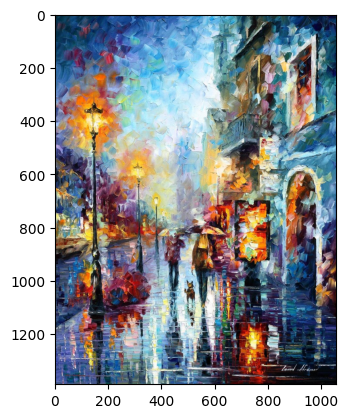

In [4]:
img = plt.imread(path+file_name+'.jpg')
plt.imshow(img)
plt.show()

In [5]:
import os
import subprocess

In [6]:
!apt install libopencv-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [7]:
!pip install nvcc4jupyter

In [8]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpjv1kd_9i".


In [9]:
COMPILER_ARGS = subprocess.check_output(["pkg-config", "--cflags", "--libs", "opencv4"]).decode().strip()
print(COMPILER_ARGS)

-I/usr/include/opencv4 -lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [10]:
%%cuda --compiler-args "$COMPILER_ARGS"

#include <iostream>
#include <numeric>
#include <stdlib.h>
#include <stdio.h>
#include <string>

#include <opencv2/core/core.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <opencv2/opencv.hpp>

using namespace cv;
using namespace std;

int width;
int height;
string file_name = "image";
string path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/";
float mid = 0.6;

// Max Threads
#define TxB 512

#define CUDA_CHECK_RETURN(value) CheckCudaErrorAux(__FILE__,__LINE__, #value, value)
void gamma_correction(uchar4* const d_rgbaImage,
                      uchar4* const d_greyImage,
                      size_t numRows, size_t numCols, float gamma);

//Matrices de las imagenes
cv::Mat imageMat;
cv::Mat imageMat2;
cv::Mat imageOutputMat;

//Punteros hacia el inicio de la imagen
//Necesarios para luego liberar memoria
uchar4        *d_rgbaImage__;
uchar4        *d_rgba2Image__;
uchar4        *d_outputImage__;

unsigned char *d_binaryImage__;
unsigned char *d_binary2Image__;
unsigned char *d_notImage__;

size_t numRows() { return imageMat.rows; }
size_t numCols() { return imageMat.cols; }


static void CheckCudaErrorAux (const char *file, unsigned line, const char *statement, cudaError_t err)
{
	if (err == cudaSuccess)
		return;
	std::cerr << statement<<" returned " << cudaGetErrorString(err) << "("<<err<< ") at "<<file<<":"<<line << std::endl;
	exit (1);
}


//Kernel corrección gamma
__global__
void gamma_correction_kernel(const uchar4* const rgbaImage, uchar4* const outputImage, int numRows, int numCols, float gamma)
{
  // El mapeo de los componentes uchar4 aRGBA es:
  // .x -> R ; .y -> G ; .z -> B ; .w -> A
  // Nota: Ignoramos el canal alfa
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if( i < numRows*numCols){
    uchar4 px = rgbaImage[i]; // thread pixel to process
    //printf( "Antes: R: %i G: %i B %i \n",px.x,px.y,px.z );

    unsigned char rcolor = round(pow((px.x / 255.0f), (1.0f / gamma)  ) * 255.0f);
    outputImage[i].x = (rcolor > 255.0f) ? 255.0f : rcolor;
    unsigned char gcolor = round(pow((px.y / 255.0f), (1.0f / gamma)  ) * 255.0f);
    outputImage[i].y = (gcolor > 255.0f) ? 255.0f : gcolor;
    unsigned char bcolor = round(pow((px.z / 255.0f), (1.0f / gamma)  ) * 255.0f);
    outputImage[i].z = (bcolor > 255.0f) ? 255.0f : bcolor;

    //printf( "Despues: R: %i G: %i B %i \n",outputImage[i].x,outputImage[i].y,outputImage[i].z );
  }
}

void gamma_correction(uchar4* const d_rgbaImage, uchar4* const d_outputImage, size_t numRows, size_t numCols, float gamma)
{
  // Dado que no importa la posicion relativa de los pixels
  // en este algoritmo, la estrategia para asignar hilos a
  // bloques y rejillas sera sencillamente la de cubrir
  // a todos los pixeles con hebras en el eje X
  long long int total_px = numRows * numCols;  // total pixels
  long int grids_n = ceil(total_px / TxB); // grids numer
  const dim3 blockSize(TxB, 1, 1);
  const dim3 gridSize(grids_n, 1, 1);
  gamma_correction_kernel<<<gridSize, blockSize>>>(d_rgbaImage, d_outputImage, numRows, numCols, gamma);

  cudaDeviceSynchronize();
  CUDA_CHECK_RETURN(cudaGetLastError());
}

void preProcess(uchar4 **inputImage,  uchar4  **outputImage, uchar4 **d_rgbaImage, uchar4 **d_outputImage, const std::string &filename)
{
  //Comprobar que el contexto se inicializa bien
  CUDA_CHECK_RETURN(cudaFree(0));

  cv::Mat image;
  image = cv::imread(filename.c_str()); //image = cv::imread(filename.c_str(), IMREAD_COLOR); //CV_LOAD_IMAGE_COLOR);

  if (image.empty()) {
    std::cerr << "No se pudo abrir el archivo: " << filename << std::endl;
    exit(1);
  }

  cv::cvtColor(image, imageMat, COLOR_BGR2BGRA); //CV_BGR2RGBA);

  // Reserva memoria para el output
  imageOutputMat.create(image.rows, image.cols, CV_8UC4);

  if (!imageMat.isContinuous() || !imageOutputMat.isContinuous())
  {
    std::cerr << "Images aren't continuous!! Exiting." << std::endl;
    exit(1);
  }

  //Apuntamos al comienzo de las filas
  *inputImage   = (uchar4 *)imageMat.ptr<unsigned char>(0);
  *outputImage  = (uchar4 *)imageOutputMat.ptr<unsigned char>(0);

  const size_t numPixels = numRows() * numCols();
  //Reserva memoria en el dispositivo
  CUDA_CHECK_RETURN(cudaMalloc(d_rgbaImage,   sizeof(uchar4) * numPixels));
  CUDA_CHECK_RETURN(cudaMalloc(d_outputImage, sizeof(uchar4) * numPixels));
  CUDA_CHECK_RETURN(cudaMemset(*d_outputImage, 0, numPixels * sizeof(uchar4))); // Asegurate de que no queda memoria sin liberar

  // Copia el input en la GPU
  CUDA_CHECK_RETURN(cudaMemcpy(*d_rgbaImage, *inputImage, sizeof(uchar4) * numPixels, cudaMemcpyHostToDevice));

  d_rgbaImage__   = *d_rgbaImage;
  d_outputImage__ = *d_outputImage;
}


int main(void)
{
	uchar4        *h_rgbaImage,   *d_rgbaImage;
  uchar4        *h_rgbaImage2,  *d_rgbaImage2;
  uchar4        *h_outputImage, *d_outputImage;

  //Variable para binarizar
  unsigned char *h_binaryImage,  *d_binaryImage;   //imagen binarizada
  unsigned char *h_binary2Image, *d_binary2Image;  //imagen binarizada
  unsigned char *h_notImage,     *d_notImage;      //imagen negada

  //Datos auxiliares
  std::string input_file;
  std::string output_file;
  float aux;

  //Comprobar que el contexto se inicializa bien
  CUDA_CHECK_RETURN(cudaFree(0));

  input_file   = path + file_name + ".jpg";
  output_file  = path + file_name + "_gamma_gpu.jpg";
  aux          = mid; //gamma

  // Carga la imagen y nos prepara los punteros para la entrada y
  // salida de datos
  preProcess(&h_rgbaImage, &h_outputImage,
              &d_rgbaImage, &d_outputImage, input_file);

  // Invoca al código de kernel para ser llamado.
  gamma_correction(d_rgbaImage, d_outputImage, numRows(), numCols(), aux);

  size_t numPixels = numRows()*numCols();
  CUDA_CHECK_RETURN(cudaMemcpy(h_outputImage, d_outputImage, sizeof(uchar4) * numPixels, cudaMemcpyDeviceToHost));

  /* Saca la imagen en escala de grises */
  cv::Mat output(numRows(), numCols(), CV_8UC4, (void*)h_outputImage);
  // std::cout << "M = " << std::endl << " "  << output << std::endl << std::endl;
  // Para imprimir la imagen en una ventana
  // // Abre la ventana
  // cv::namedWindow("to_bw");
  //  // Pasa la imagen a la ventana anterior
  // cv::imshow("to_bw", output);
  // cvWaitKey (0);
  // cvDestroyWindow ("to_bw");
  // Guardar a fichero
  cv::Mat MatOutput;
  cv::cvtColor(output, MatOutput, cv::COLOR_RGBA2BGR );
  cv::imwrite(output_file.c_str(), MatOutput);

  /* Libera memoria */
  cudaFree(d_rgbaImage__);
  cudaFree(d_outputImage__);


	return 0;
}


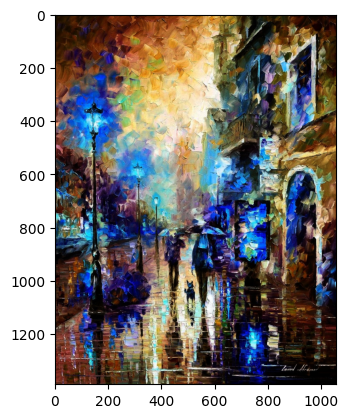

In [11]:
img = plt.imread(path+file_name+'_gamma_gpu.jpg')
plt.imshow(img)
plt.show()

In [12]:
img = plt.imread(path+file_name+'.jpg')

mid = 0.6 # gamma

# METODO 1: RGB

# convertir img a gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# compute gamma = log(mid*255)/log(mean)
mean = np.mean(gray)
gamma = math.log(mid*255)/math.log(mean)
print(gamma)

# gamma correction
img_gamma1 = np.power(img, gamma).clip(0,255).astype(np.uint8)

# METODO 2: HSV

# convertir img to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue, sat, val = cv2.split(hsv)

# compute gamma = log(mid*255)/log(mean)

mean = np.mean(val)
gamma = math.log(mid*255)/math.log(mean)
print(gamma)

# gamma correction on value channel
val_gamma = np.power(val, gamma).clip(0,255).astype(np.uint8)

# combine new value channel with original hue and sat channels
hsv_gamma = cv2.merge([hue, sat, val_gamma])
img_gamma2 = cv2.cvtColor(hsv_gamma, cv2.COLOR_HSV2BGR)

# guardando resultados
cv2.imwrite(path+file_name+'_gamma_python1.jpg', img_gamma1)
cv2.imwrite(path+file_name+'_gamma_python2.jpg', img_gamma2)

cv2.waitKey(0)
cv2.destroyAllWindows()

1.0441176025885728
0.9999797041175528


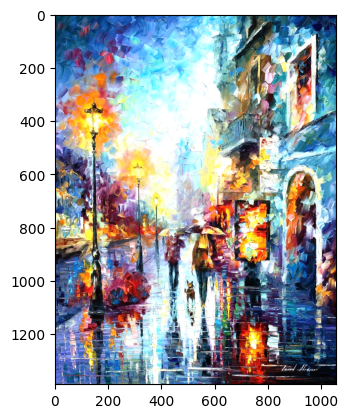

In [13]:
plt.imshow(img_gamma1)
plt.show()

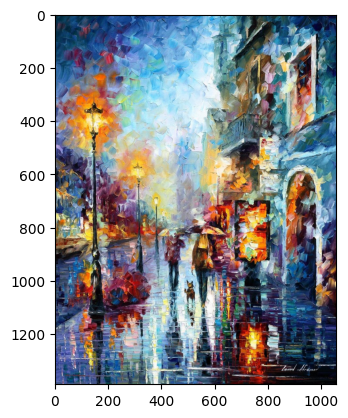

In [14]:
plt.imshow(img_gamma2)
plt.show()